In [12]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.9 MB 559.3 kB/s eta 0:00:05
   ------- -------------------------------- 0.5/2.9 MB 559.3 kB/s eta 0:00:05
   ---------- ----------------------------- 0.8/2.9 MB 609.8 kB/s eta 0:00:04
   -------------- ------------------------- 1.0/2.9 MB 687.8 kB/s eta 0:00:03
   -------------- ------------------------- 1.0/2.9 MB 687.8 kB/s eta 0:00:03
   ------------------ --------------------- 1.3/2.9 MB 682.9 kB/s eta 0:00:03
   --------------------- ------------------ 1.6/2.9 MB 718.1 kB/s eta 0:00:02
   --------------------- ------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
    --------------------------------------- 0.3/12.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.0 MB 2.1 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/12.0 MB 2.2 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/12.0 MB 2.2 MB/s eta 0:00:05
   ------ --------------------------------- 1.8/12.0 MB 1.7 MB/s eta 0:00:06
   ------ --------------------------------- 1.8/12.0 MB 1.7 MB/s eta 0:00:06
   ------ --------------------------------- 1.8/12.0 MB 1.7 MB/s eta 0:00:06
   ------ --------------------------------- 2.1/12.0 MB 1.3 MB/s eta 0:00:08
   ------ --------------------------------- 2.1/12.0 MB 1.3 MB/s eta 0:00:08
   ------- -------------------------------- 2.4/12.0 MB 1.1 MB/s eta 0:00:09
   ------- -------------------------------- 2.4/12.0 MB 1.1 MB/s eta 0:00:09
   ------- -

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install rouge-score

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24971 sha256=9d836366d1338d31e178efbeebbf9d466e74742555bc1714bcc04c3d10452f6d
  Stored in directory: c:\users\abhisek\appdata\local\pip\cache\wheels\44\af\da\5ffc433e2786f0b1a9c6f458d5fb8f611d8eb332387f18698f
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [1]:
# If running in a fresh environment, uncomment these:
# !pip install tensorflow datasets transformers matplotlib pillow pyyaml

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Ensure the local `src` package is importable so `from model import ...` works
# This inserts the `src` folder (relative to the notebook working dir) into sys.path.
# If your notebook working dir is different, adjust the path accordingly.
sys.path.insert(0, os.path.abspath('src'))

import tensorflow as tf
from datasets import load_dataset
from transformers import BertTokenizerFast

from model import build_compiled_model, load_config
from utils import (
    set_seed,
    get_tokenizer,
    preprocess_example_builder,
    load_and_prepare_datasets,
    make_tf_dataset,
)


In [2]:
# Load configuration
config_path = "config.yaml"
cfg = load_config(config_path)

# Reproducibility
seed = cfg["training"].get("seed", 42)
set_seed(seed)

print("Project:", cfg["project"]["name"])
print("Description:", cfg["project"]["description"])
print("Seed:", seed)

Project: CrossModalTemporalAttention
Description: Cross-modal temporal attention model for story reasoning over image sequences and captions.
Seed: 42


In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))


TensorFlow version: 2.20.0-rc0
GPU devices: []


In [4]:
dcfg = cfg.get('dataset', {})
hf_name = dcfg.get('hf_name', 'daniel3303/StoryReasoning')

print(f"Loading raw HuggingFace dataset: {hf_name}")
raw = load_dataset(hf_name)

print(raw)
print("Available splits:", raw.keys())

# Peek at a few raw examples from the base split (usually 'train')
base_split_name = dcfg.get('train_split', next(iter(raw.keys())))
print("\nSample example from base split:", base_split_name)

# Configured keys (may be missing or wrong for some HF datasets)
frames_key_cfg = dcfg.get('frames_key')
captions_key_cfg = dcfg.get('captions_key')
reason_key_cfg = dcfg.get('reason_key')

# Candidate keys to try when the config key is absent
candidate_frame_keys = ['images', 'frames', 'frame_paths', 'image_list', 'image', 'frames_list']
candidate_caption_keys = ['captions', 'caption', 'caption_text', 'text', 'story']

for i in range(2):
    ex = raw[base_split_name][i]
    print(f"\n--- Example {i} ---")

    # Determine frames key (prefer config, else try candidates)
    frames_key = None
    if frames_key_cfg and frames_key_cfg in ex:
        frames_key = frames_key_cfg
    else:
        for k in candidate_frame_keys:
            if k in ex:
                frames_key = k
                break

    if frames_key is None:
        print('Warning: no frame-like key found in example. Available keys:', list(ex.keys()))
        print('Please update config.yaml dataset.frames_key to one of the above or fix dataset.')
    else:
        try:
            val = ex[frames_key]
            # If the frames field is an object describing images (datasets Image feature), len() still works
            print(f'Frames (key={frames_key}):', len(val))
        except Exception as e:
            print('Could not get frames length for key', frames_key, 'error:', e)

    # Determine caption key
    caption_key = None
    if captions_key_cfg and captions_key_cfg in ex:
        caption_key = captions_key_cfg
    else:
        caption_key = next((k for k in candidate_caption_keys if k in ex), None)

    if caption_key is None:
        print('No caption-like key found. Available keys:', list(ex.keys()))
    else:
        print(f'Captions (key={caption_key}):', ex.get(caption_key))

    # Reason (optional)
    reason_val = None
    if reason_key_cfg and reason_key_cfg in ex:
        reason_val = ex.get(reason_key_cfg)
    else:
        reason_val = ex.get('reason', None)
    print('Reason (if present):', reason_val)


Loading raw HuggingFace dataset: daniel3303/StoryReasoning
DatasetDict({
    train: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 3552
    })
    test: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 626
    })
})
Available splits: dict_keys(['train', 'test'])

Sample example from base split: train

--- Example 0 ---
Frames (key=images): 17
Captions (key=story): <gdi image1>
In the sterile environment of a sparse room filled with <gdo obj1>cardboard boxes</gdo>, <gdo obj5>a blue blanket</gdo>, and <gdo bg26>a table</gdo>, <gdo char1>James</gdo> <gda char1>enters</gda> with a neutral look. His face reflects the calm before the storm. <gdo char1>James</gdo> <gda char1>enters</gda> an empty room that holds the remnants of what looks like a hastily abandoned office. The room's <gdl bg1>neutral lighting</gdl> and <gdl bg2>simple, minimalistic architecture</gd

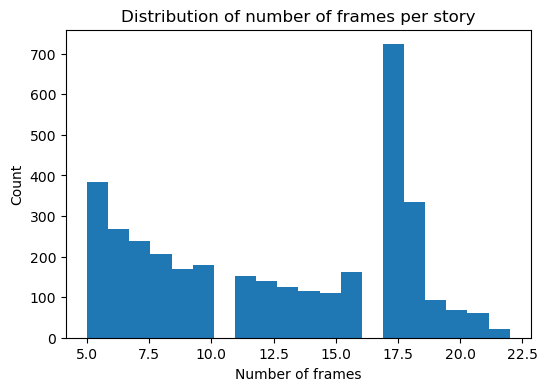

Min frames: 5
Max frames: 22
Mean frames: 12.443412162162161


In [5]:
# Robustly resolve which key contains frames and compute counts (handles single-image values)
frames_key_cfg = dcfg.get('frames_key')
base = raw[base_split_name]

candidate_frame_keys = ['images', 'frames', 'frame_paths', 'image_list', 'image', 'frames_list']

def resolve_frames_field(example):
    if frames_key_cfg and frames_key_cfg in example:
        return example[frames_key_cfg]
    for k in candidate_frame_keys:
        if k in example:
            return example[k]
    return None

num_frames_list = []
for ex in base:
    val = resolve_frames_field(ex)
    if val is None:
        n = 0
    else:
        try:
            n = len(val)
        except TypeError:
            # single image/path/object -> count as 1
            n = 1
    num_frames_list.append(n)

plt.figure(figsize=(6,4))
plt.hist(num_frames_list, bins=20)
plt.title("Distribution of number of frames per story")
plt.xlabel("Number of frames")
plt.ylabel("Count")
plt.show()

if len(num_frames_list) > 0:
    print("Min frames:", np.min(num_frames_list))
    print("Max frames:", np.max(num_frames_list))
    print("Mean frames:", np.mean(num_frames_list))
else:
    print('No frame counts available (empty split or keys not found).')


Token indices sequence length is longer than the specified maximum sequence length for this model (3325 > 512). Running this sequence through the model will result in indexing errors


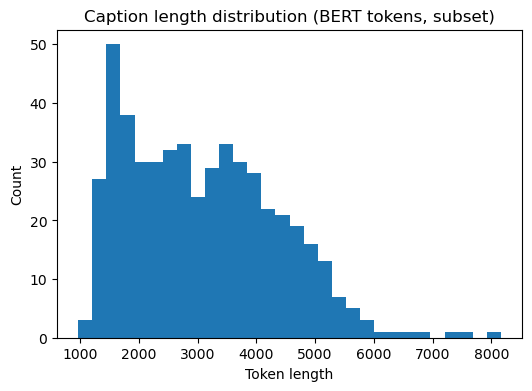

Min caption length: 965
Max caption length: 8163
Mean caption length: 3093.736


In [6]:
# Compute caption length distribution robustly (handles missing/varied caption keys)
tokenizer = get_tokenizer()
captions_key_cfg = dcfg.get('captions_key')
candidate_caption_keys = ['captions', 'caption', 'caption_text', 'text', 'story', 'sentences']

all_caption_lengths = []

# Work on a subset for speed; `base` is the split dataset object from earlier
try:
    subset = base.select(range(min(500, len(base))))
except Exception:
    subset = base[:min(500, len(base))]

for ex in subset:
    # Resolve caption field: prefer config, else try candidates
    cap_val = None
    if captions_key_cfg and captions_key_cfg in ex:
        cap_val = ex[captions_key_cfg]
    else:
        for k in candidate_caption_keys:
            if k in ex:
                cap_val = ex[k]
                break
    if cap_val is None:
        # nothing to process for this example
        continue

    # Normalize to a list of caption strings
    caps = []
    if isinstance(cap_val, list):
        caps = cap_val
    elif isinstance(cap_val, str):
        caps = [cap_val]
    elif isinstance(cap_val, dict):
        # try common nested text keys inside a dict
        for nk in ('text', 'caption', 'captions'):
            if nk in cap_val:
                v = cap_val[nk]
                if isinstance(v, list):
                    caps = v
                else:
                    caps = [v]
                break
        if not caps:
            # fallback to stringifying the dict
            caps = [str(cap_val)]
    else:
        # fallback: convert to string
        caps = [str(cap_val)]

    for cap in caps:
        if cap is None:
            continue
        try:
            tokens = tokenizer.encode(cap, add_special_tokens=True)
            all_caption_lengths.append(len(tokens))
        except Exception:
            # skip entries that tokenizer cannot handle
            continue

plt.figure(figsize=(6,4))
if len(all_caption_lengths) > 0:
    plt.hist(all_caption_lengths, bins=30)
    plt.title("Caption length distribution (BERT tokens, subset)")
    plt.xlabel("Token length")
    plt.ylabel("Count")
    plt.show()
    print("Min caption length:", np.min(all_caption_lengths))
    print("Max caption length:", np.max(all_caption_lengths))
    print("Mean caption length:", np.mean(all_caption_lengths))
else:
    print('No captions found in the subset. Available example keys:', list(subset[0].keys()) if len(subset) > 0 else '[]')


In [7]:
print("Splitting and preprocessing dataset (70% train, 15% val, 15% test)...")
train_hf, val_hf, test_hf = load_and_prepare_datasets(cfg)

print("\nPreprocessed dataset sizes:")
print("Train:", len(train_hf))
print("Val:  ", len(val_hf))
print("Test: ", len(test_hf))


Splitting and preprocessing dataset (70% train, 15% val, 15% test)...
Loading HuggingFace dataset: daniel3303/StoryReasoning
Creating 70% train, 15% val, 15% test split from base split: train
Sizes:
  Train: 2486
  Val:   533
  Test:  533
Creating 70% train, 15% val, 15% test split from base split: train
Sizes:
  Train: 2486
  Val:   533
  Test:  533
Preprocessing train set...
Preprocessing train set...
Preprocessing validation set...
Preprocessing validation set...


Map:   0%|          | 0/533 [00:00<?, ? examples/s]

Preprocessing test set...

Preprocessed dataset sizes:
Train: 2486
Val:   533
Test:  533


In [8]:
print("Converting HF datasets to tf.data.Dataset pipelines...")

train_tf = make_tf_dataset(train_hf, cfg, shuffle=True)
val_tf   = make_tf_dataset(val_hf, cfg, shuffle=False)
test_tf  = make_tf_dataset(test_hf, cfg, shuffle=False)

print("tf.data.Dataset pipelines ready.")

Converting HF datasets to tf.data.Dataset pipelines...
tf.data.Dataset pipelines ready.
tf.data.Dataset pipelines ready.


In [9]:
print("Building and compiling CrossModalTemporalAttention model...")
model = build_compiled_model(config=cfg)
model.summary()


Building and compiling CrossModalTemporalAttention model...




Model: "CrossModalTemporalAttention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_captions    │ (None, 3, 32)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ images (InputLayer) │ (None, 3, 128,    │          0 │ -                 │
│                     │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reason (InputLayer) │ (None, 32)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_caption      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CrossModalTemporal… │ (None, 32, 30522) │ 41,119,915 │ context_captions… │
│ (CrossModalTempora… │                   │            │ images[0][0],     │
│                     │                   │            │ reason[0][0],     │
│                     │                   │            │ target_caption[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,119,915 (156.86 MB)

 Trainable params: 41,119,915 (156.86 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
tcfg = cfg["training"]
save_dir = tcfg["save_dir"]
os.makedirs(save_dir, exist_ok=True)

checkpoint_path = os.path.join(save_dir, "best_model_notebook.h5")

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=tcfg.get("save_best_only", True),
    monitor=tcfg.get("monitor_metric", "val_loss"),
    mode="min",
    save_weights_only=False,
    verbose=1,
)

early_cb = tf.keras.callbacks.EarlyStopping(
    monitor=tcfg.get("monitor_metric", "val_loss"),
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

epochs = tcfg["epochs"]
batch_size = cfg["dataset"]["batch_size"]

# -----------------------------
# 🔥 Compute steps manually
# -----------------------------
train_steps = len(train_hf) // batch_size
val_steps = len(val_hf) // batch_size

print(f"Training for {epochs} epochs...")
print(f"Steps per epoch: {train_steps}")
print(f"Validation steps: {val_steps}")

history = model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=epochs,
    steps_per_epoch=train_steps,       # 👈 added
    validation_steps=val_steps,        # 👈 added
    callbacks=[ckpt_cb, early_cb],
    verbose=1,                         # always show progress
)


Training for 5 epochs...
Steps per epoch: 155
Validation steps: 33
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 7.0595
Epoch 1: val_loss improved from None to 4.10622, saving model to results_tf/checkpoints\best_model_notebook.h5

Epoch 1: val_loss improved from None to 4.10622, saving model to results_tf/checkpoints\best_model_notebook.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 814s 4s/step - loss: 5.3180 - val_loss: 4.1062
Epoch 2/5
Epoch 2/5
  1/155 ━━━━━━━━━━━━━━━━━━━━ 3:08 1s/step - loss: 3.9450

C:\Users\Abhisek\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 4.10622 to 4.10511, saving model to results_tf/checkpoints\best_model_notebook.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 82s 523ms/step - loss: 3.9450 - val_loss: 4.1051
Epoch 3/5
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 4.0387
Epoch 3: val_loss improved from 4.10511 to 3.97339, saving model to results_tf/checkpoints\best_model_notebook.h5

Epoch 3: val_loss improved from 4.10511 to 3.97339, saving model to results_tf/checkpoints\best_model_notebook.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 800s 4s/step - loss: 4.0108 - val_loss: 3.9734
Epoch 4/5
Epoch 4/5
  1/155 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - loss: 3.8686
Epoch 4: val_loss improved from 3.97339 to 3.97245, saving model to results_tf/checkpoints\best_model_notebook.h5

Epoch 4: val_loss improved from 3.97339 to 3.97245, saving model to results_tf/checkpoints\best_model_notebook.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 88s 563ms/step - loss: 3.8686 - val_loss: 3.9724
Epoch 5/5
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.8953
Epoch 5: val_loss improved from 3.97245 to 3.81986, saving model to results_tf/checkpoints\best_model_notebook.h5

Epoch 5: val_loss improved from 3.97245 to 3.81986, saving model to results_tf/checkpoints\best_model_notebook.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - loss: 3.8632 - val_loss: 3.8199
Restoring model weights from the end of the best epoch: 5.
Restoring model weights from the end of the best epoch: 5.


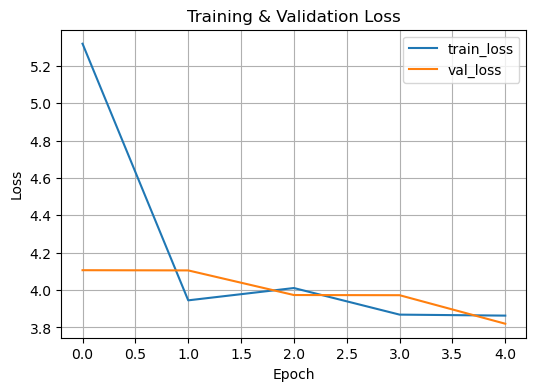

In [12]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import math

print("Evaluating on test set...")

batch_size = cfg["dataset"]["batch_size"]

# number of batches (round up so we cover all samples)
test_steps = math.ceil(len(test_hf) / batch_size)

test_metrics = model.evaluate(
    test_tf,
    steps=test_steps,      # 👈 tell Keras how many steps
    return_dict=True,
    verbose=1,             # make sure progress is printed
)

print("Test metrics:", test_metrics)


Evaluating on test set...
34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 3.8563
Test metrics: {'loss': 3.8562703132629395}
34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 3.8563
Test metrics: {'loss': 3.8562703132629395}


In [15]:
# Reuse tokenizer from earlier cell
tokenizer = get_tokenizer()
max_caption_len = dcfg["max_caption_len"]

def decode_ids(ids):
    # ids: numpy array or list of token IDs
    # skip padding (0) and special tokens if desired
    ids = [int(i) for i in ids]
    # Remove padding (0)
    ids = [i for i in ids if i != 0]
    # Decode using tokenizer (it will handle [CLS], [SEP], etc.)
    text = tokenizer.decode(ids, skip_special_tokens=True)
    return text.strip()

def get_predictions_from_batch(model, batch_x):
    """
    model: compiled Keras model
    batch_x: dict with keys as in make_tf_dataset (images, context_captions, target_caption, reason)
    Returns:
      pred_ids: (B, T) argmax predictions
    """
    logits = model.predict(batch_x, verbose=0)  # (B, T, vocab_size)
    pred_ids = np.argmax(logits, axis=-1)       # (B, T)
    return pred_ids


In [16]:
# Take one batch from test_tf
test_iter = iter(test_tf)
batch_x, batch_y = next(test_iter)  # batch_y is (B, T) ground truth token ids

pred_ids = get_predictions_from_batch(model, batch_x)

num_show = min(5, pred_ids.shape[0])

for i in range(num_show):
    gt_ids = batch_y[i].numpy()
    pr_ids = pred_ids[i]

    gt_text = decode_ids(gt_ids)
    pr_text = decode_ids(pr_ids)

    print(f"\n================ Example {i} ================")
    print("Ground-truth caption:")
    print(gt_text)
    print("\nPredicted caption:")
    print(pr_text)



================ Example 0 ================
Ground-truth caption:
< gdi image1 > the < gdo bg1 > indoor office or workspace < / gdo > was dimly lit, the atmosphere

Predicted caption:
< < g g g g > g g > > > > > > > > > > < > g g > > > > > > > g

================ Example 1 ================
Ground-truth caption:
< gdi image1 > the warm sunlight filtered through the < gdl bg3 > tree < / gdl > leaves, casting dapp

Predicted caption:
< < g g g g > > > > > > < g > > > > > > < > g > > > > > > > g

================ Example 2 ================
Ground-truth caption:
< gdi image1 > under the vast < gdo bg2 > sky < / gdo >, < gdo char6 > mrs

Predicted caption:
< < g g g g > > > g g > > > > > > < > g g > > < g g > > > > g

================ Example 3 ================
Ground-truth caption:
< gdi image1 > in the dimly lit, stark room of an old building, < gdo char5 > the patient < / gdo

Predicted caption:
< < g g g g > > > > > > > > > > > > < g g > > > > > < > g g g

================ Example 4 ===

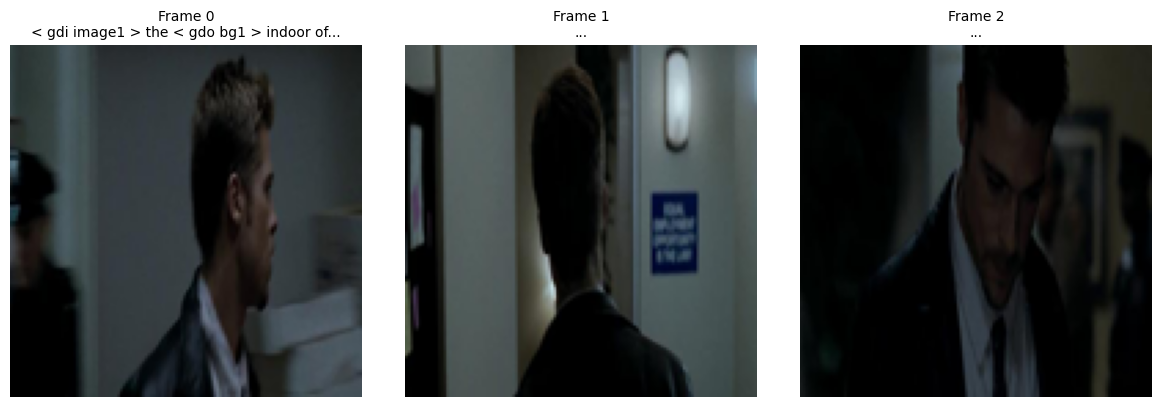

Target (GT): < gdi image1 > the < gdo bg1 > indoor office or workspace < / gdo > was dimly lit, the atmosphere
Predicted  : < < g g g g > g g > > > > > > > > > > < > g g > > > > > > > g


In [17]:
S = dcfg["seq_len"]
image_size = dcfg["image_size"]

# pick example index
idx = 0

images = batch_x["images"][idx].numpy()  # (S, H, W, 3)
ctx_caps_ids = batch_x["context_captions"][idx].numpy()  # (S, T)

plt.figure(figsize=(4 * S, 4))
for t in range(S):
    ax = plt.subplot(1, S, t+1)
    ax.imshow(images[t])
    ax.axis("off")
    ctx_text = decode_ids(ctx_caps_ids[t])
    ax.set_title(f"Frame {t}\n{ctx_text[:40]}...", fontsize=10)
plt.tight_layout()
plt.show()

print("Target (GT):", decode_ids(batch_y[idx].numpy()))
print("Predicted  :", decode_ids(pred_ids[idx]))


In [18]:
import numpy as np
import math
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# make sure NLTK is ready (no download needed for BLEU)
tokenizer = get_tokenizer()   # same as before

def decode_ids(ids):
    ids = [int(i) for i in ids if int(i) != 0]   # drop PAD=0
    return tokenizer.decode(ids, skip_special_tokens=True).strip()

def get_predictions_from_batch(model, batch_x):
    logits = model.predict(batch_x, verbose=0)   # (B, T, vocab)
    return np.argmax(logits, axis=-1)           # (B, T)

print("Computing BLEU on test set...")

refs = []   # list of list-of-tokens: [[ref1_tokens], [ref2_tokens], ...]
hyps = []   # list of tokens: [hyp1_tokens, hyp2_tokens, ...]

for batch_x, batch_y in test_tf:
    pred_ids = get_predictions_from_batch(model, batch_x)
    gt_ids   = batch_y.numpy()

    for i in range(pred_ids.shape[0]):
        ref_text = decode_ids(gt_ids[i])
        hyp_text = decode_ids(pred_ids[i])

        refs.append([ref_text.split()])   # corpus_bleu expects list of refs
        hyps.append(hyp_text.split())

smooth = SmoothingFunction().method1
bleu = corpus_bleu(refs, hyps, smoothing_function=smooth)
print(f"Corpus BLEU: {bleu:.4f}")


Computing BLEU on test set...
Corpus BLEU: 0.0016
Corpus BLEU: 0.0016


In [19]:
import math

print("Evaluating on test set for perplexity...")

batch_size = cfg["dataset"]["batch_size"]
test_steps = math.ceil(len(test_hf) / batch_size)

test_metrics = model.evaluate(
    test_tf,
    steps=test_steps,
    return_dict=True,
    verbose=1,
)

test_loss = test_metrics["loss"]
perplexity = math.exp(test_loss)
print(f"Test loss: {test_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")


Evaluating on test set for perplexity...
34/34 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 3.8563
Test loss: 3.8563
Perplexity: 47.2887
34/34 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 3.8563
Test loss: 3.8563
Perplexity: 47.2887
